In [1]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import rfpimp

from sklearn import feature_selection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from IPython.core.pylabtools import figsize 
%matplotlib inline

In [2]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]
    
def univariate_auc(dataset, variable_name):
    le = LabelEncoder()
    sorted_dataset = dataset[[variable_name, "TYPE"]].sort_values(by=variable_name).dropna()
    fpr, tpr, _ = roc_curve(le.fit_transform(sorted_dataset.TYPE), sorted_dataset[[variable_name]])
    return auc(fpr, tpr)

def balanced_accuracy(dataset, variable_name):
    
    dataset = dataset[[variable_name, "TYPE"]].sort_values(by=variable_name).dropna()
    tp = dataset[(dataset.TYPE == "Pathogenic") & (~dataset[variable_name])].shape[0]
    p = dataset[dataset.TYPE == "Pathogenic"].shape[0]
    tn = dataset[(dataset.TYPE == "Benign") & (~dataset[variable_name])].shape[0]
    n = dataset[dataset.TYPE == "Benign"].shape[0]
    return (tp/p + tn/n) / 2

In [3]:
RANDOM_STATE = 42

In [4]:
structural_dataset = pd.read_csv("../data/processed/structural/dataset.csv.gz", index_col="MUTANT")

In [5]:
structural_dataset.shape

(68508, 50)

In [10]:
structural_dataset.TYPE.value_counts(normalize=True)

Polymorphism    0.578808
Disease         0.421192
Name: TYPE, dtype: float64

In [8]:
structural_dataset.columns

Index(['TYPE', 'CHARGE', 'VOLUME', 'HYDROPHOBICITY', 'GRANTHAM', 'POLARITY',
       'EX', 'PAM250', 'BLOSUM', 'JM', 'VB', 'TRANSITION', 'BINDING',
       'ACT_SITE', 'SITE', 'LIPID', 'METAL', 'CARBOHYD', 'DNA_BIND', 'NP_BIND',
       'CA_BIND', 'DISULFID', 'SE_CYS', 'MOD_RES', 'PROPEP', 'SIGNALP',
       'TRANSMEM', 'COMPBIAS', 'REP', 'MOTIF', 'ZN_FING', 'REGIONS', 'PPI',
       'RNABD', 'TF', 'LOC', 'MMBRBD', 'CHROM', 'POSTMODREC', 'POSTMODENZ',
       'AROMATICITY_DIFF', 'AROMATICITY_LOG_RATIO', 'ISOELECTRIC_POINT_DIFF',
       'ISOELECTRIC_POINT_LOG_RATIO', 'GRAVY_DIFF', 'GRAVY_LOG_RATIO',
       'INSTABILITY_INDEX_DIFF', 'INSTABILITY_INDEX_LOG_RATIO',
       'FLEXIBILITY_DIFF', 'FLEXIBILITY_LOG_RATIO'],
      dtype='object')

In [9]:
le = LabelEncoder()
X = structural_dataset[~structural_dataset.TYPE.isnull()].drop(['TYPE'], 1)
y = le.fit_transform(structural_dataset[~structural_dataset.TYPE.isnull()].TYPE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [12]:
cat_vars = ['BINDING','ACT_SITE','SITE','LIPID','METAL','CARBOHYD','DNA_BIND','NP_BIND',
            'CA_BIND','DISULFID','SE_CYS','MOD_RES','PROPEP','SIGNALP','TRANSMEM','COMPBIAS',
            'REP','MOTIF','ZN_FING','REGIONS','PPI','RNABD','TF','LOC','MMBRBD','CHROM','POSTMODREC','POSTMODENZ']
cont_vars = X.columns.drop(cat_vars, 1).tolist()

impute = ('union', 
          FeatureUnion(
              transformer_list=[
                  ('continuous', Pipeline([
                      ('selector', ItemSelector(key=cont_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="median"))
                  ])),
                  ('categorical', Pipeline([
                      ('selector', ItemSelector(key=cat_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="most_frequent"))
                      
                  ]))
              ]))
                  

# impute = ('imputer', Imputer(missing_values="NaN", strategy="median"))

scale = ('scaler', RobustScaler())

model_dict = {
    'lr':{'pipe':[impute, scale, ('lr', LogisticRegression())],
        'params':[{'lr__C' : [.001, .01, .1, 1, 10, 100, 1000], 'lr__class_weight':[None, 'balanced']}],
        'name':'LogisticRegression'
    },
    'rf':{'pipe':[impute, ('rf', RandomForestClassifier(random_state=RANDOM_STATE))],
        'params':[{'rf__max_depth':[3,5,7], 'rf__n_estimators':[10,50,100], 'rf__max_features':[4,'sqrt',0.2, 7, 15]}],
        'name':'Random Forest'
    },
    'svc':{'pipe': [impute, scale, ('svc', SVC(kernel='rbf'))],
           'params':[{'svc__kernel': ['rbf'], 'svc__gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                'svc__C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}]
        
    },
}

In [13]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
algorithm = 'rf'
model = Pipeline(model_dict[algorithm]['pipe'])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=2, 
                  scoring='roc_auc', verbose=1, refit=True)

In [14]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   34.6s
[Parallel(n_jobs=2)]: Done 135 out of 135 | elapsed:  2.3min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fce3dc226d0>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key=['CHARGE', 'VOLUME', 'HYDROPHOBICITY', 'GRANTHAM', 'POLARITY', 'EX', 'PAM250', 'BLOSUM', 'JM', 'VB', 'TRANSITION', 'AROMATICITY_DIFF', 'AROMATICITY_LOG_RATI...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid=[{'rf__max_depth': [3, 5, 7], 'rf__n_estimators': [10, 50, 100], 'rf__max_features': [4, 'sqrt', 0.2, 7, 15]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [15]:
rf = gs.best_estimator_

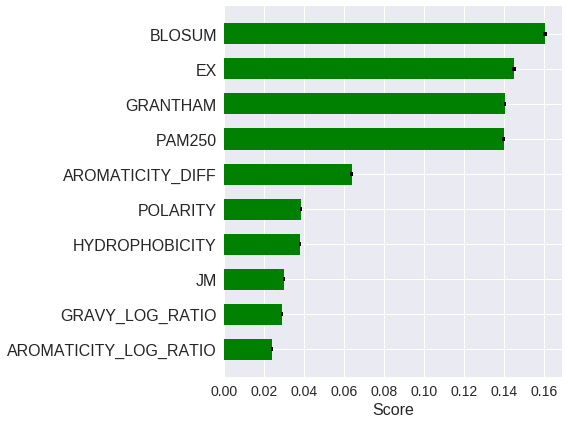

In [16]:
cols = (cont_vars + cat_vars)
ranking_size = 10
forest = rf.steps[1][1]

importances = [(cols[e], x) for e, x in enumerate(forest.feature_importances_)]
importances.sort(key=operator.itemgetter(1), reverse=True)
indices = np.argsort(forest.feature_importances_)[:ranking_size]
importances = importances[:ranking_size][::-1]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
plt.figure(figsize=(8,6))
plt.barh(np.arange(len(importances)), [y for x, y in importances], 0.6, color="green", align="center", 
         xerr=std[indices], ecolor="black", error_kw={"capthick":2, "capsize":2})
plt.yticks(range(len(importances)), [x for x, y in importances], rotation='horizontal', fontsize=16)
plt.xlabel("Score",fontsize=16)
plt.xticks(fontsize=14)
plt.tight_layout()

# plt.savefig("/home/marlan/Desktop/importances_structural.pdf", bbox_inches='tight', pad_inches=0.1)


In [17]:
y_test

array([0, 0, 0, ..., 1, 1, 0])

In [18]:
features1 = ["GRANTHAM", "EX", "PAM250", "BLOSUM", "JM", "VB"] 
features2 = ["HYDROPHOBICITY", "POLARITY"]
features3 = ["CHARGE", "ISOELECTRIC_POINT_LOG_RATIO"]
features = X.drop(features1+features2+features3, axis=1).columns.tolist() + [features1] + [features2] + [features3]


In [19]:
I = rfpimp.importances(rf, X_test, y_test, n_samples=-1, features=features)

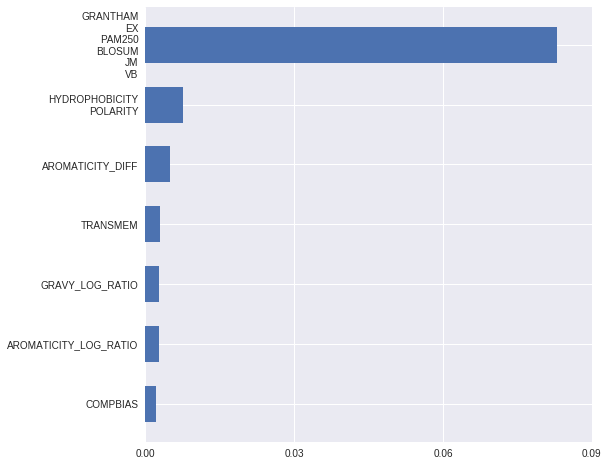

In [20]:
rfpimp.plot_importances(I.iloc[:7], label_fontsize=10, scalefig=(2,2), figsize=(8,8), save="/home/marlan/Desktop/structural_importance_cluster.pdf")

In [21]:
for variable in cont_vars:
    print(variable, ":", univariate_auc(structural_dataset, variable))
print("------")
for variable in cat_vars:
    print(variable, ":", balanced_accuracy(structural_dataset, variable))

CHARGE : 0.4959177471972145
VOLUME : 0.520292049506456
HYDROPHOBICITY : 0.483655340022012
GRANTHAM : 0.36501648901678213
POLARITY : 0.48422069012627156
EX : 0.6465599909603277
PAM250 : 0.6430130873264853
BLOSUM : 0.6505629091605836
JM : 0.6037220574244376
VB : 0.5790575631137371
TRANSITION : 0.5344343045119992
AROMATICITY_DIFF : 0.4084825999279935
AROMATICITY_LOG_RATIO : 0.4700004170819586
ISOELECTRIC_POINT_DIFF : 0.44140267299674407
ISOELECTRIC_POINT_LOG_RATIO : 0.49252107559281133
GRAVY_DIFF : 0.45110473580328025
GRAVY_LOG_RATIO : 0.5160697292819646
INSTABILITY_INDEX_DIFF : 0.5065023433549424
INSTABILITY_INDEX_LOG_RATIO : 0.5179209254701685
FLEXIBILITY_DIFF : 0.45827101647559776
FLEXIBILITY_LOG_RATIO : 0.5266021438364478
------


TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


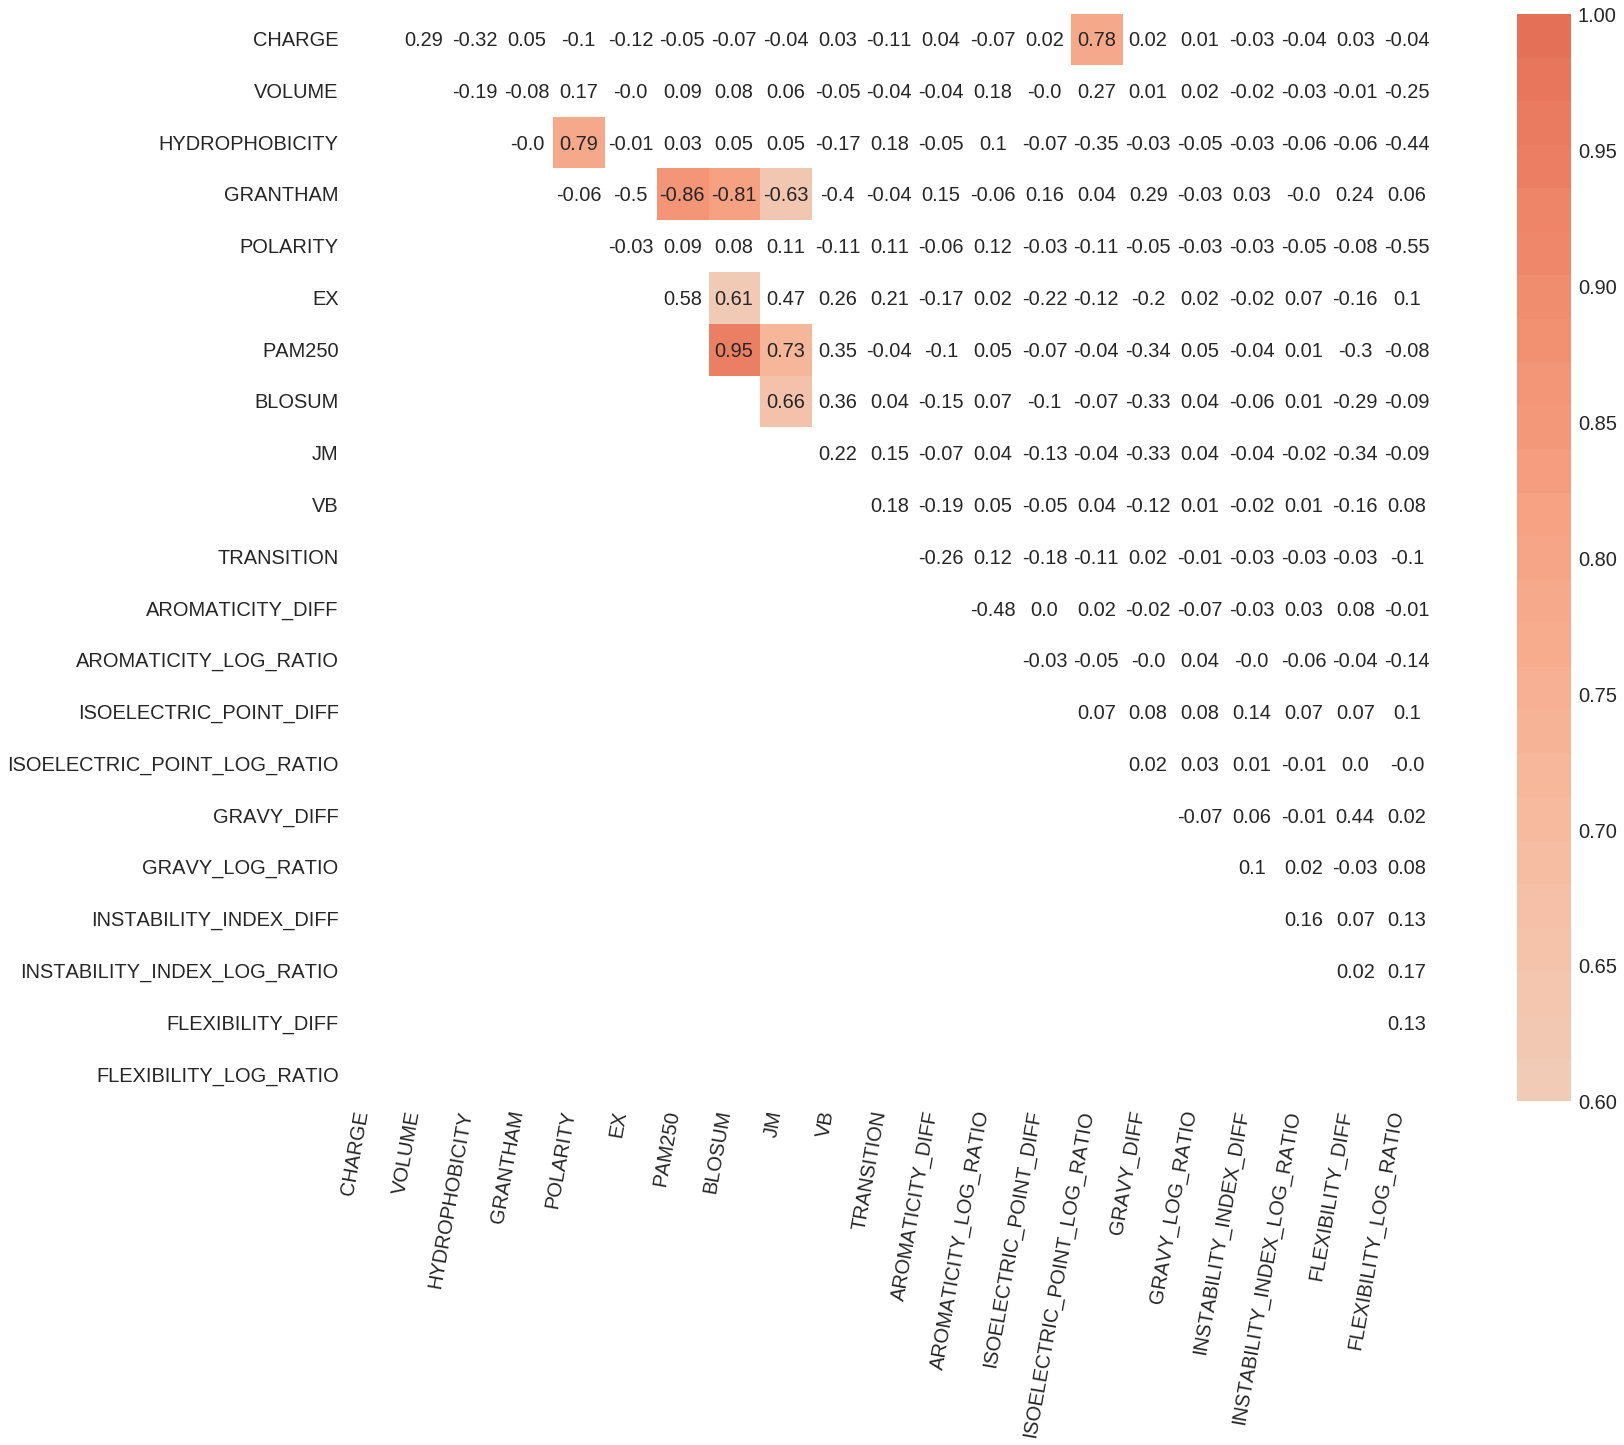

In [22]:
%load_ext autoreload
%autoreload 2
rfpimp.plot_corr_heatmap(X[cont_vars], figsize=(30,20), value_fontsize=20, label_fontsize=20, show=False, save="/home/marlan/Desktop/structural_corr.pdf")

In [22]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [24]:
roc_curve = pd.concat([pd.Series(fpr,name="fpr"), pd.Series(tpr, name="tpr")], axis=1)
roc_curve.to_csv("../results/structural/auc_rf.csv", index=False)

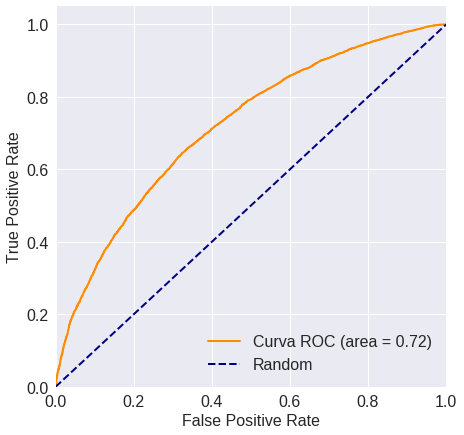

In [23]:
figsize(7,7)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('AUC Curve')
plt.legend(loc="lower right", prop={'size': 16})

# plt.savefig("/home/marlan/Desktop/auc_structural.pdf", bbox_inches='tight', pad_inches=0.1)

In [15]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(rf.predict(X_test))))

/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


              precision    recall  f1-score   support

     Disease       0.65      0.48      0.55      9522
Polymorphism       0.68      0.81      0.74     13086

 avg / total       0.67      0.67      0.66     22608



/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
